In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform
import seaborn as sns
import os
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA

if platform.system() == 'Windows':
    path  = 'c:/Windows/Fonts/malgun.ttf'
    font_name=font_manager.FontProperties(fname = path).get_name()
    rc('font',family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    print('Check your OS system')

plt.rcParams['axes.unicode_minus'] = False  

In [3]:
df = pd.read_csv('data/merged_data/Total_updated_data.csv')
df['연월'] = pd.to_datetime(df['연월'], errors='coerce')

df_corr = df[(df['연월'].dt.year >= 2022) & (df['연월'].dt.year <= 2023)]

base_columns = ['거주인구', '지하철_승객_수', '버스승객수', '대중교통_승객_수', '발생건수', '사망자수', '부상자수']
weather_columns = [
    '평균기온', '평균최고기온', '극점최고기온', '평균최저기온', '극점최저기온',
    '강수량', '평균습도', '최저습도', '해면기압', '이슬점온도',
    '평균운량', '일조시간', '최심신적설', '평균풍속', '최대풍속', '최대순간풍속'
]
target_columns = [col for col in base_columns + weather_columns if col in df.columns]

os.makedirs('heatmaps', exist_ok=True)
correlation_dict = {}

for region in df['구'].dropna().unique():
    df_region = df_corr[df_corr['구'] == region]

    corr_matrix = df_region[target_columns].corr(method='pearson').round(2)
    correlation_dict[region] = corr_matrix

    plt.figure(figsize=(14, 10))
    sns.set(font=font_name, rc={"axes.unicode_minus": False})
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f'2022~2023 {region} 상관관계 히트맵', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'heatmaps/{region}_히트맵.png', dpi=300)
    plt.close()

In [4]:
gu_vectors = {}
for gu, corr_df in correlation_dict.items():
    cols = corr_df.columns
    pair_names = [f'{cols[i]}_{cols[j]}' for i, j in zip(*np.triu_indices(len(cols), k=1))]
    flat_values = corr_df.values[np.triu_indices_from(corr_df, k=1)]
    gu_vectors[gu] = pd.Series(flat_values, index=pair_names)

df_vectors = pd.DataFrame(gu_vectors).T

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

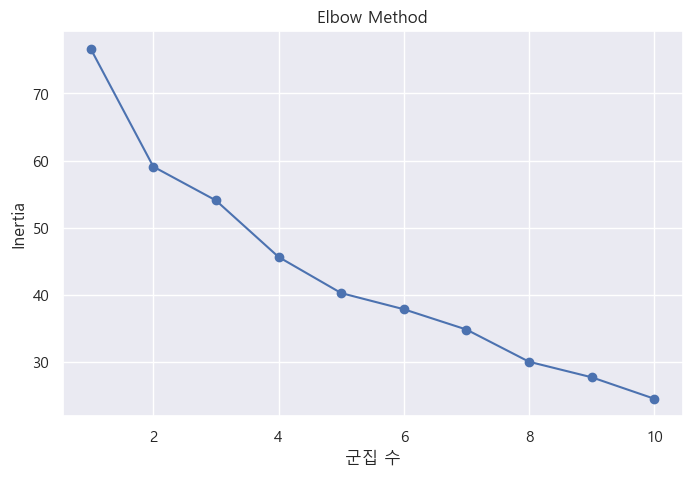

In [5]:
inertias = []
k_range = range(1, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_vectors)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('군집 수')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


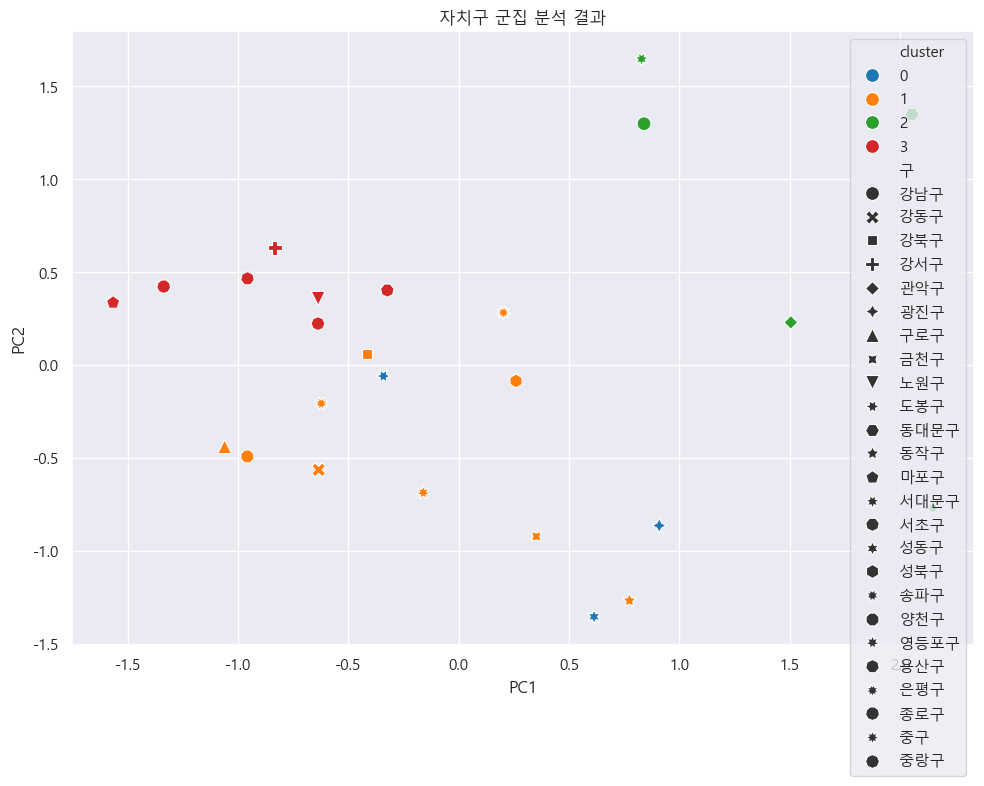

In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_vectors)
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['구'] = df_vectors.index

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(df_vectors)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', style='구', palette='tab10', s=100)
plt.title('자치구 군집 분석 결과')
plt.tight_layout()
plt.show()

In [7]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_vectors)

df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['구'] = df_vectors.index

kmeans = KMeans(n_clusters=4, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(df_vectors)

correlation_features = df_vectors.columns
pc1_weights = pd.Series(pca.components_[0], index=correlation_features)
pc2_weights = pd.Series(pca.components_[1], index=correlation_features)

top_pc1 = pc1_weights.abs().sort_values(ascending=False).head(15)
top_pc2 = pc2_weights.abs().sort_values(ascending=False).head(15)

print("PC1에서 가장 크게 기여한 상관쌍:")
print(top_pc1)
print('--------------------------------')
print("PC2에서 가장 크게 기여한 상관쌍:")
print(top_pc2)


PC1에서 가장 크게 기여한 상관쌍:
거주인구_지하철_승객_수     0.319896
거주인구_대중교통_승객_수    0.279101
거주인구_버스승객수        0.258003
거주인구_평균습도         0.181075
거주인구_평균풍속         0.180590
부상자수_이슬점온도        0.165688
부상자수_평균습도         0.160705
부상자수_평균최저기온       0.160019
부상자수_극점최저기온       0.158334
거주인구_최저습도         0.157858
부상자수_평균운량         0.156626
부상자수_평균기온         0.156416
거주인구_발생건수         0.155144
부상자수_평균최고기온       0.150271
부상자수_강수량          0.144190
dtype: float64
--------------------------------
PC2에서 가장 크게 기여한 상관쌍:
거주인구_지하철_승객_수     0.297380
거주인구_대중교통_승객_수    0.237202
거주인구_평균풍속         0.224698
거주인구_버스승객수        0.214013
부상자수_평균최고기온       0.169961
부상자수_극점최고기온       0.168845
거주인구_발생건수         0.165567
부상자수_평균기온         0.163318
거주인구_평균습도         0.158640
부상자수_평균최저기온       0.154140
거주인구_최저습도         0.153868
부상자수_해면기압         0.153166
부상자수_극점최저기온       0.147032
부상자수_이슬점온도        0.146838
발생건수_극점최고기온       0.141359
dtype: float64


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [8]:
df_pca_sorted = df_pca[['구', 'cluster']].sort_values(by='cluster')
df_pca_sorted.to_csv('heatmaps/자치구_군집분포.csv', index=False, encoding='utf-8-sig')


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


PCA 1 축 영향 큰 상관쌍 인덱스: [0 7]
PCA 2 축 영향 큰 상관쌍 인덱스: [65 62]


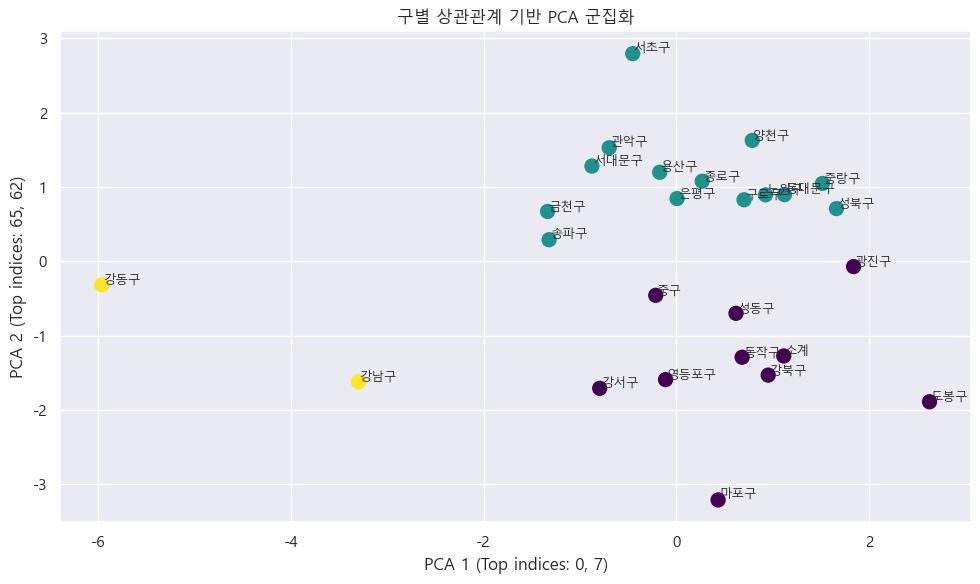

In [9]:
df = pd.read_csv("data/merged_data/merged_result_updated.csv")

df_filtered = df[(df['연도'] >= 2017) & (df['연도'] <= 2023)]

numeric_cols = df_filtered.select_dtypes(include=[np.number]).columns.drop(['연도'])

gu_corr_dict = {}
for gu, sub_df in df_filtered.groupby('구'):
    if len(sub_df) >= 2:
        gu_corr_dict[gu] = sub_df[numeric_cols].corr()

columns_by_gu = {gu: set(corr_df.columns) for gu, corr_df in gu_corr_dict.items()}
common_columns = sorted(list(set.intersection(*columns_by_gu.values())))

gu_vectors = {}
for gu, corr_df in gu_corr_dict.items():
    common_corr = corr_df.loc[common_columns, common_columns]
    upper_triangle = common_corr.where(np.triu(np.ones(common_corr.shape), k=1).astype(bool))
    gu_vectors[gu] = upper_triangle.stack().values

min_length = min(len(vec) for vec in gu_vectors.values())
gu_vectors_trimmed = {gu: vec[:min_length] for gu, vec in gu_vectors.items()}

df_vectors = pd.DataFrame(gu_vectors_trimmed).T
df_vectors.fillna(0, inplace=True)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_vectors)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)

x_top_idx = np.argsort(np.abs(pca.components_[0]))[::-1][:2]
y_top_idx = np.argsort(np.abs(pca.components_[1]))[::-1][:2]

print("PCA 1 축 영향 큰 상관쌍 인덱스:", x_top_idx)
print("PCA 2 축 영향 큰 상관쌍 인덱스:", y_top_idx)

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', s=100)
for i, gu in enumerate(df_vectors.index):
    plt.text(pca_result[i, 0]+0.01, pca_result[i, 1]+0.01, gu, fontsize=9)

plt.xlabel(f"PCA 1 (Top indices: {x_top_idx[0]}, {x_top_idx[1]})")
plt.ylabel(f"PCA 2 (Top indices: {y_top_idx[0]}, {y_top_idx[1]})")
plt.title("구별 상관관계 기반 PCA 군집화")
plt.grid(True)
plt.tight_layout()
plt.show()


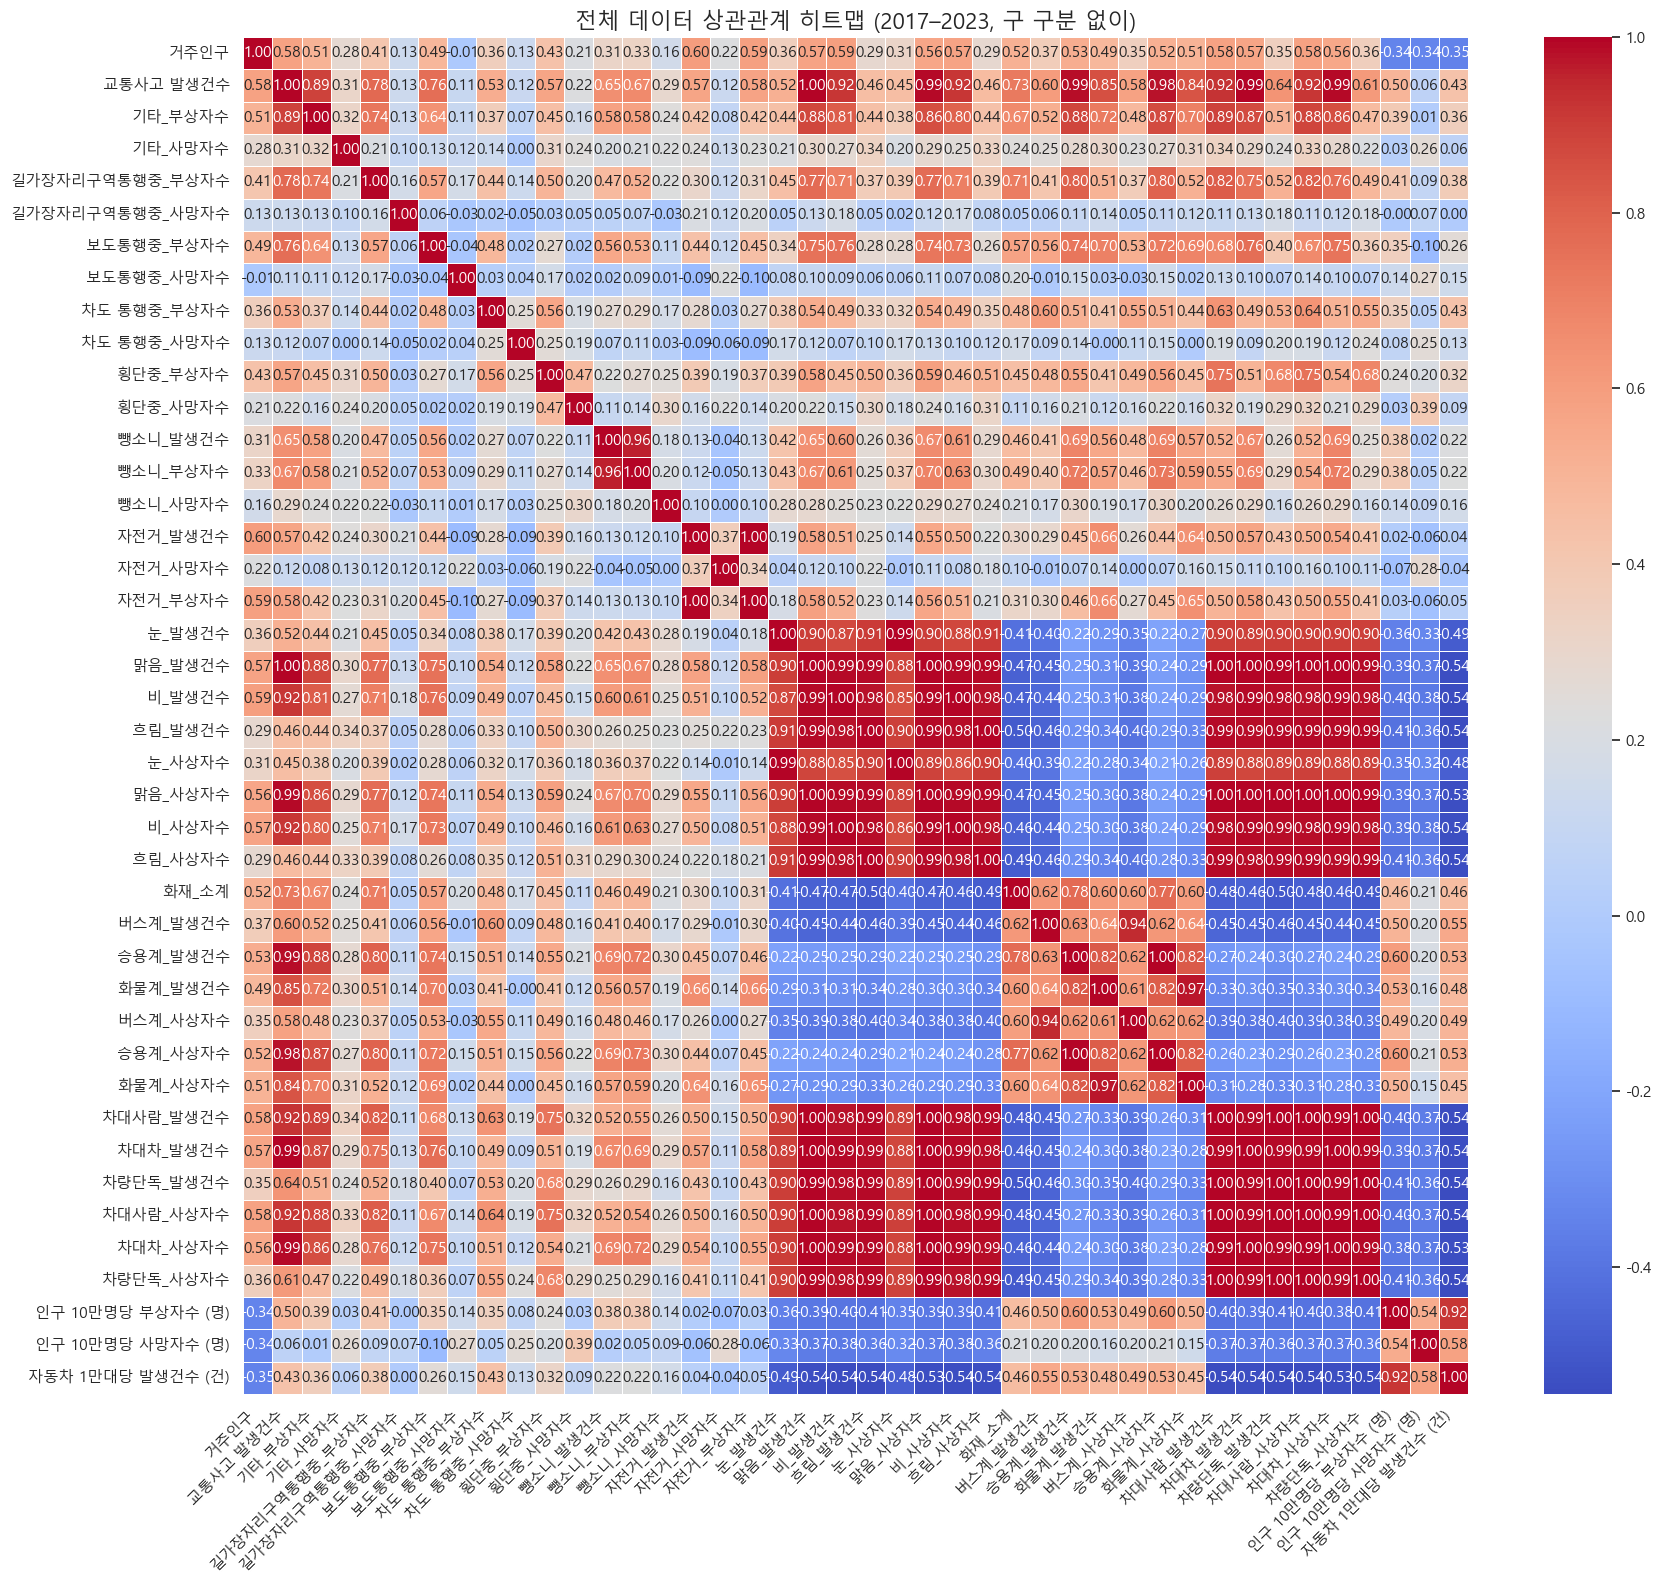

In [10]:
df_all = pd.read_csv("data/merged_data/merged_result_updated.csv")
df_all_filtered = df_all[(df_all['연도'] >= 2017) & (df_all['연도'] <= 2023)]
numeric_all = df_all_filtered.select_dtypes(include=[np.number]).drop(columns=['연도'])

corr_all = numeric_all.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(
    corr_all, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5,
    annot_kws={'size': 11}
)
plt.title("전체 데이터 상관관계 히트맵 (2017–2023, 구 구분 없이)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

In [11]:
corr_pairs = (
    corr_all.where(np.triu(np.ones(corr_all.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

corr_pairs.columns = ['변수1', '변수2', '상관계수']
corr_pairs['절댓값'] = corr_pairs['상관계수'].abs()

def get_prefix(varname):
    return varname.split('_')[0] 

corr_pairs['prefix1'] = corr_pairs['변수1'].apply(get_prefix)
corr_pairs['prefix2'] = corr_pairs['변수2'].apply(get_prefix)
filtered_corr = corr_pairs[corr_pairs['prefix1'] != corr_pairs['prefix2']]

high_corr = filtered_corr[filtered_corr['절댓값'] >= 0.7]

high_corr_sorted = high_corr.sort_values(by='절댓값', ascending=False)
print(high_corr_sorted[['변수1', '변수2', '상관계수']])
print(f"출력된 상관관계 쌍 개수: {high_corr_sorted.shape[0]}")


                 변수1       변수2      상관계수
625          맑음_발생건수  차대차_사상자수  0.999754
703          맑음_사상자수  차대차_사상자수  0.999554
622          맑음_발생건수  차대차_발생건수  0.999140
700          맑음_사상자수  차대차_발생건수  0.998341
58         교통사고 발생건수   맑음_발생건수  0.997844
..               ...       ...       ...
478         뺑소니_부상자수  차대차_사상자수  0.715505
179  길가장자리구역통행중_부상자수     화재_소계  0.712803
177  길가장자리구역통행중_부상자수    비_사상자수  0.708714
173  길가장자리구역통행중_부상자수    비_발생건수  0.707471
253       보도통행중_부상자수  화물계_발생건수  0.700081

[144 rows x 3 columns]
출력된 상관관계 쌍 개수: 144


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

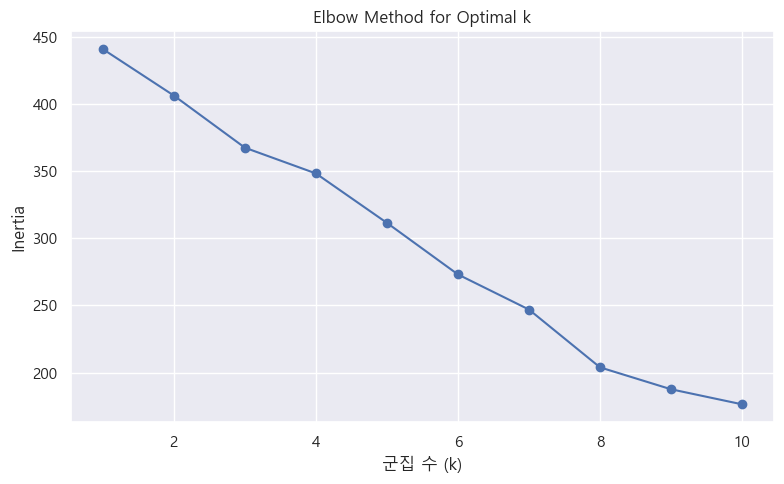

In [12]:
df = pd.read_csv("data/merged_data/merged_result_updated.csv")
df_filtered = df[(df['연도'] >= 2017) & (df['연도'] <= 2023)]
numeric_cols = df_filtered.select_dtypes(include=[np.number]).columns.drop(['연도'])

gu_corr_dict = {}
for gu, sub_df in df_filtered.groupby('구'):
    if len(sub_df) >= 2:
        gu_corr_dict[gu] = sub_df[numeric_cols].corr()

columns_by_gu = {gu: set(corr_df.columns) for gu, corr_df in gu_corr_dict.items()}
common_columns = sorted(list(set.intersection(*columns_by_gu.values())))

gu_vectors = {}
mask = np.triu(np.ones((len(common_columns), len(common_columns)), dtype=bool), k=1)
for gu, corr_df in gu_corr_dict.items():
    upper_triangle = corr_df.loc[common_columns, common_columns].where(mask)
    gu_vectors[gu] = upper_triangle.stack().values

min_len = min(len(v) for v in gu_vectors.values())
gu_vectors_trimmed = {gu: v[:min_len] for gu, v in gu_vectors.items()}

pair_names = [f"{i}_{j}" for i in common_columns for j in common_columns if i < j]

df_vectors = pd.DataFrame(gu_vectors_trimmed).T
df_vectors.columns = pair_names[:df_vectors.shape[1]]
df_vectors.fillna(0, inplace=True)

inertias = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_vectors)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('군집 수 (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



===== k = 3 =====
 PCA 1 주요 상관쌍 TOP 10:
1. 거주인구_교통사고 발생건수 (0.2457)
2. 거주인구_맑음_발생건수 (0.2209)
3. 거주인구_차대차_발생건수 (0.2052)
4. 교통사고 발생건수_눈_발생건수 (0.1975)
5. 거주인구_인구 10만명당 부상자수 (명) (0.1914)
6. 거주인구_비_사상자수 (0.1863)
7. 거주인구_뺑소니_사망자수 (0.1861)
8. 거주인구_승용계_발생건수 (0.1702)
9. 거주인구_횡단중_사망자수 (0.1669)
10. 거주인구_흐림_발생건수 (0.1655)

 PCA 2 주요 상관쌍 TOP 10:
1. 교통사고 발생건수_자전거_사망자수 (0.2367)
2. 교통사고 발생건수_자동차 1만대당 발생건수 (건) (-0.2191)
3. 거주인구_비_사상자수 (-0.2028)
4. 교통사고 발생건수_비_발생건수 (-0.1923)
5. 기타_부상자수_맑음_사상자수 (-0.1885)
6. 거주인구_맑음_사상자수 (-0.1857)
7. 거주인구_화재_소계 (0.1841)
8. 교통사고 발생건수_뺑소니_사망자수 (0.1827)
9. 거주인구_차량단독_사상자수 (-0.1789)
10. 교통사고 발생건수_비_사상자수 (-0.1780)


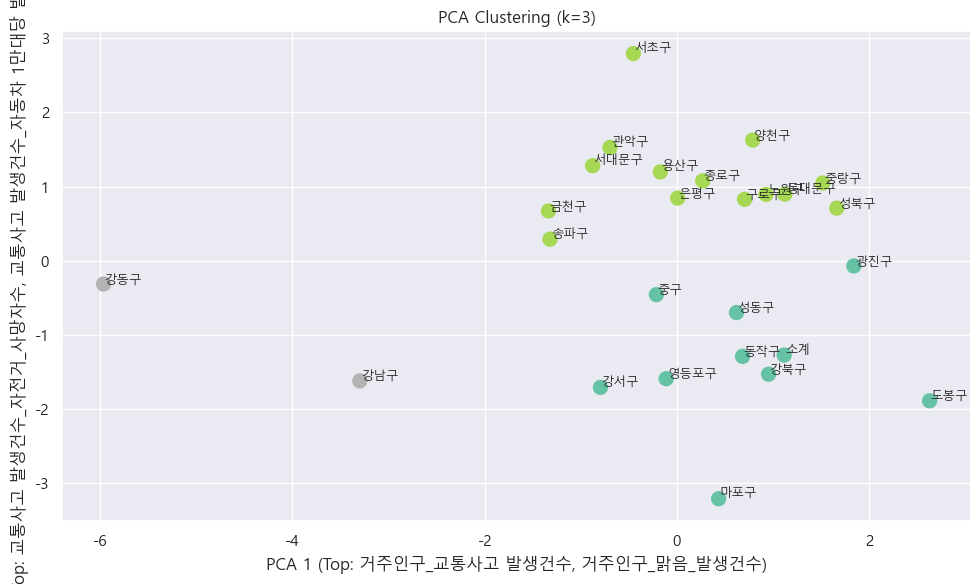

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



===== k = 8 =====
 PCA 1 주요 상관쌍 TOP 10:
1. 거주인구_교통사고 발생건수 (0.2457)
2. 거주인구_맑음_발생건수 (0.2209)
3. 거주인구_차대차_발생건수 (0.2052)
4. 교통사고 발생건수_눈_발생건수 (0.1975)
5. 거주인구_인구 10만명당 부상자수 (명) (0.1914)
6. 거주인구_비_사상자수 (0.1863)
7. 거주인구_뺑소니_사망자수 (0.1861)
8. 거주인구_승용계_발생건수 (0.1702)
9. 거주인구_횡단중_사망자수 (0.1669)
10. 거주인구_흐림_발생건수 (0.1655)

 PCA 2 주요 상관쌍 TOP 10:
1. 교통사고 발생건수_자전거_사망자수 (0.2367)
2. 교통사고 발생건수_자동차 1만대당 발생건수 (건) (-0.2191)
3. 거주인구_비_사상자수 (-0.2028)
4. 교통사고 발생건수_비_발생건수 (-0.1923)
5. 기타_부상자수_맑음_사상자수 (-0.1885)
6. 거주인구_맑음_사상자수 (-0.1857)
7. 거주인구_화재_소계 (0.1841)
8. 교통사고 발생건수_뺑소니_사망자수 (0.1827)
9. 거주인구_차량단독_사상자수 (-0.1789)
10. 교통사고 발생건수_비_사상자수 (-0.1780)


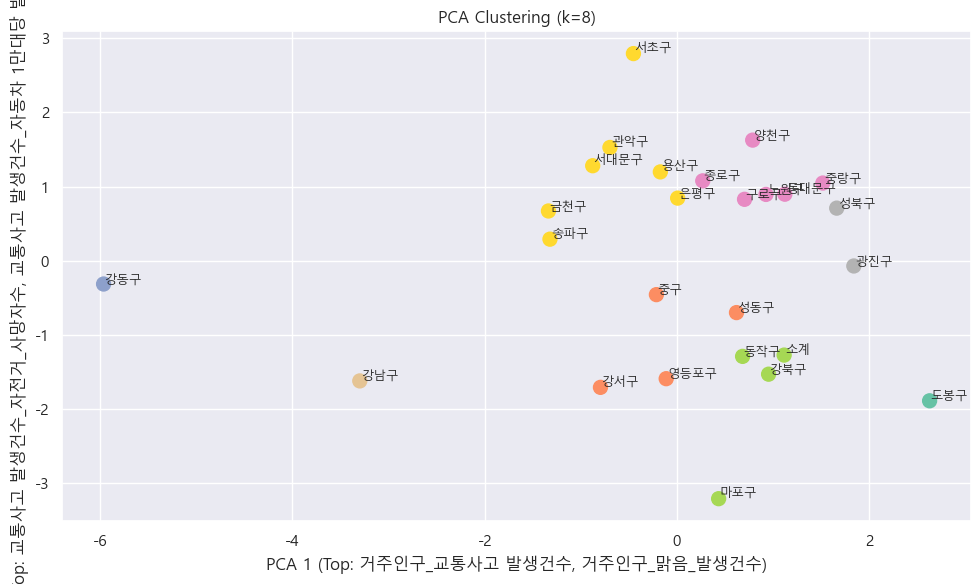

In [13]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_vectors)

column_names = list(df_vectors.columns)

for k in [3, 8]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(pca_result)

    x_idx = np.argsort(np.abs(pca.components_[0]))[::-1][:10]
    y_idx = np.argsort(np.abs(pca.components_[1]))[::-1][:10]
    x_pairs = [column_names[i] for i in x_idx]
    y_pairs = [column_names[i] for i in y_idx]

    print(f"\n===== k = {k} =====")
    print(" PCA 1 주요 상관쌍 TOP 10:")
    for i, pair in enumerate(x_pairs):
        weight = pca.components_[0][x_idx[i]]
        print(f"{i+1}. {pair} ({weight:.4f})")

    print("\n PCA 2 주요 상관쌍 TOP 10:")
    for i, pair in enumerate(y_pairs):
        weight = pca.components_[1][y_idx[i]]
        print(f"{i+1}. {pair} ({weight:.4f})")

    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='Set2', s=100)
    for i, gu in enumerate(df_vectors.index):
        plt.text(pca_result[i, 0]+0.01, pca_result[i, 1]+0.01, gu, fontsize=9)

    plt.xlabel(f"PCA 1 (Top: {x_pairs[0]}, {x_pairs[1]})")
    plt.ylabel(f"PCA 2 (Top: {y_pairs[0]}, {y_pairs[1]})")
    plt.title(f"PCA Clustering (k={k})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
